/home/rk-nagai/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


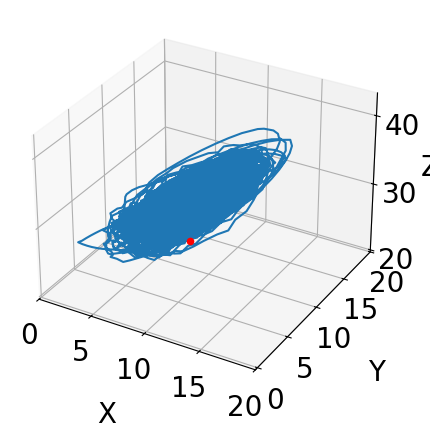

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
from random import randrange
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
import matplotlib.pyplot as plt
import time
from datetime import datetime
plt.rcParams.update({'font.size': 20})


D=0.5
x01=np.array([8.20747939, 10.0860429, 23.86324441])

num=1

PH=113


nowstr = datetime.now().strftime("%m-%d-%Y_%H-%M-%S_")

seed = 1  # seed of random numbers
torch.manual_seed(int(seed)) # initialization of seed of random numbers for pytorch
np.random.seed(seed)
v0 = np.zeros((3, PH))
v1 = np.zeros((3, PH))
v2 = np.zeros((3, PH))



class L63(nn.Module):
    def __init__(self, T, size):
        # Define various parameters.
        super(L63, self).__init__()

        # Length of the prediction horizon.
        self.predictionHorizon = T

        # Total number of control steps.
        self.MPCfinalTime = 8000

        # Number of backpropagation iterations.
        self.m=10
        # Batch size
        self.batchSize = 1
        # Learning rate
        self.lr =10
        # ReLU function
        self.relu = nn.ReLU()
        # Magnitude of the norm of the control input.
        self.D=size


        # Initialize the first 8 steps of future inputs to zero.
        
        self.x0 = torch.tensor(np.array([0,0,0]))
        self.x1 = torch.tensor(np.array([0,0,0]))
        self.x2 = torch.tensor(np.array([0,0,0]))
        self.x3 = torch.tensor(np.array([0,0,0]))
        self.x4 = torch.tensor(np.array([0,0,0]))
        self.x5 = torch.tensor(np.array([0,0,0]))
        self.x6 = torch.tensor(np.array([0,0,0]))
        self.x7 = torch.tensor(np.array([0,0,0]))
      

        # Initialize the control inputs for the prediction horizon with random values.
        self.v = nn.Parameter(torch.normal(0, 1, size=(3, self.predictionHorizon-1)))
        # Set the parameters of the Lorenz equations.
        self.p=torch.tensor(10)
        self.r=torch.tensor(32)
        self.b=torch.tensor(8/3)
        # Discretize one step as 0.01.
        self.Ts = torch.tensor(0.01)

       
    # Discretize using the fourth-order Runge-Kutta method.
    def RK4(self,xold):
        xnew=torch.zeros(3)
        k1=torch.zeros(3)
        k2=torch.zeros(3)
        k3=torch.zeros(3)
        k4=torch.zeros(3)

        k1=self.florenzcontrol(xold)
        k2=self.florenzcontrol(xold+k1*self.Ts/2.)
        k3=self.florenzcontrol(xold+k2*self.Ts/2.)
        k4=self.florenzcontrol(xold+k3*self.Ts)
        
        xnew[0]=xold[0]+self.Ts/6.0*(k1[0]+2.0*k2[0]+2.0*k3[0]+k4[0])
        xnew[1]=xold[1]+self.Ts/6.0*(k1[1]+2.0*k2[1]+2.0*k3[1]+k4[1])
        xnew[2]=xold[2]+self.Ts/6.0*(k1[2]+2.0*k2[2]+2.0*k3[2]+k4[2])
        return xnew

    # A function to advance the nature run by one step.
    def forward(self,x, u):
        self.x0 = self.f(x,u)

    # A function to normalize the control input so that its magnitude becomes the norm size D
    def norm(self,v):
        r=math.sqrt(v[0].clone()*v[0].clone()+v[1].clone()*v[1].clone()+v[2].clone()*v[2].clone())
          
        return v/r*self.D
    
    
    # A function to compute the derivative of the Lorenz equations
    def florenzcontrol(self, x):
        dxyz=torch.zeros_like(x)
        dxyz[0] = -self.p * x[0].clone() + self.p * x[1].clone()
        dxyz[1] = (self.r - x[2].clone()) * x[0].clone() - x[1].clone()
        dxyz[2] = x[0].clone() * x[1].clone() - self.b * x[2].clone()

        return dxyz
    
    # Update the nature run using the control input.
    def f(self, x, u):
        # Initialize the next state
        x_next=torch.zeros(3)
        # Compute the next state using the 4th-order Runge-Kutta method
        x_next=self.RK4(x)
        # Apply control input to the next state
        x_next[0]=x_next[0]+u[0] #update of x
        x_next[1]=x_next[1]+u[1] #update of y
        x_next[2]=x_next[2]+u[2] #update of z   
        
        return x_next


    # A function to compute the stage cost for model predictive control.
    def stageCost(self, x, u):
            
        cost=self.relu(-x[0])
        
        return cost
    
    # A function to compute the terminal cost.
    def finalStageCost(self, x):
        cost=self.relu(-x[0])   
        return cost
        
    # A function to compute future states for the prediction horizon.
    def trajectoryforMPC(self,u):
        # Initialize state trajectory matrix (3 states × prediction horizon)
        x = torch.zeros(3, self.predictionHorizon)
        # Set initial state with added Gaussian noise (mean=0, variance=2)
        x[:, 0] = self.x0.float()+np.random.normal(loc=0,scale=math.sqrt(2),size=3) # Compute the predicted values under incomplete observations.
        # Compute the state at the first time step using the given control input u
        x[:, 1] = self.f(x[:, 0], u)
        for i in range(1, self.predictionHorizon-1):
             # Apply the normalized control input and compute the next state
             x[:, i+1] = self.f(x[:, i], self.norm(self.v[:, [i]]))
        return x

    # A function to compute the cost function over the prediction horizon.
    def sampleJforMPC(self, u, T):
        x = self.trajectoryforMPC(u)
        cost = torch.tensor(0)
        for i in range(T-1):
            cost = cost + self.stageCost(x[:, i], self.norm(self.v[:, [i]]))
        return cost + self.finalStageCost(x[:, T-1])

    # Compute the cost function for the number of batch size samples.
    def sampleBatchJforMPC(self, u, T):
        cost = torch.zeros(( self.batchSize))
        for i in range(self.batchSize):
            cost[i] = self.sampleJforMPC(u, T)
        return cost

    # A function to update the control input using the backpropagation method.
    def unfoldTrainForMPC(self, currentInput):
        global v0,v1,v2 # Global variables to store intermediate values of self.v
         # Initialize the optimizer (Adam) with the learning rate
        opt = optim.Adam(self.parameters(), lr=self.lr)
        # Set the model to training mode
        self.train()
        

        # Define the loss function (L1 Loss)
        loss_func = nn.L1Loss()
        # Create a target tensor of zeros for batch size
        target = torch.zeros([1,self.batchSize])
        # Training loop for m iterations
        for i in range(self.m):
            # Zero the gradients before backpropagation
            opt.zero_grad()
            # Compute the loss based on the cost function of the batch
            loss_func(self.sampleBatchJforMPC(currentInput, self.predictionHorizon),target).backward(retain_graph=True)
            # Update the parameters using the optimizer
            opt.step()
            




def MPC(x0, size):
    # Set the prediction horizon
    predictionHorizon = PH
    # Define the control update cycle
    cycle=8
    
    # Initialize the Lorenz-63 model with the given prediction horizon and size
    myModel = L63(predictionHorizon, size)
    myModel.x0 = torch.tensor(x0) # Set the initial state

    # Initialize arrays to store states (x) and control inputs (u)
    x = np.zeros((3, myModel.MPCfinalTime+1))
    u = np.zeros((3, myModel.MPCfinalTime+1))

    # Loop over the total control cycles (1000 DA cycles in practice)
    for i in range(int((myModel.MPCfinalTime)/cycle)): 
        
        # Store the current state
        x[:, cycle*i] = myModel.x0.detach().numpy()

        # Train the model using backpropagation to optimize the control input
        myModel.unfoldTrainForMPC(u[:, [i]])
        
        # Apply the optimized control inputs over the cycle
        for j in range(cycle):
            u[:, cycle*i+j] = myModel.norm(myModel.v[:, j]).detach().numpy()

        # Forward simulation of the system using the control inputs
        for j in range(cycle):
            myModel.forward(torch.from_numpy(x[:,cycle*i+j].astype(np.float32)).clone(),u[:, cycle*i+j])
            x[:,cycle*i+j+1] = myModel.x0.detach().numpy()

        # Update the initial state for the next iteration
        newx0 = myModel.x0.detach()
        myModel = L63(predictionHorizon, size)
        myModel.x0 = newx0
      
    x[:, myModel.MPCfinalTime] = myModel.x0.detach().numpy()
    return x, u

# Run the MPC function with initial state x01 and parameter D
x1,u1=MPC(x01,D)

# Plot the 3D trajectory of the system
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(projection="3d")
# Plot the initial state as a red point
ax.scatter(*x1[:, 0], c="red")
# Plot the trajectory in 3D space
ax.plot(x1[0],x1[1],x1[2])

# Set axis labels
ax.set_xlabel('X', labelpad=20) 
ax.set_ylabel('Y', labelpad=20)  
ax.zlabel=ax.set_zlabel('Z')

# Set tick marks for X and Y axes
plt.xticks([0,5,10,15,20])
plt.yticks([0,5,10,15,20])

# Save the plot as a PDF file.
plt.savefig(f"D={D},pH={PH}.pdf")
plt.show()